<h1><center>"Tweet Sentiment Extraction – Extract support  phrases for sentiment labels" </center></h1>

### Business Problem :

With all of the tweets circulating every second it is hard to tell whether 
the sentiment behind a specific tweet will impact a company, or a 
person's, brand for being viral (positive), or devastate profit because it 
strikes a negative tone.Capturing sentiment in language is important in these times where 
decisions and reactions are created and updated in seconds. But, which 
words actually lead to the sentiment description?
In this case study we will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

### Deep Learning Problem :

Develop a Deep Learning model which performs as better as humans to identifying the words or phrases which makes tweets positive or making or neutral.

### Data Overview :

The data set has been taken from [Kaggle Competiton](https://www.kaggle.com/c/tweet-sentiment-extraction/overview/description) which has two files --- train.csv and test.csv.<br>
The train.csv has a total of four columns :
- textID : unique id for each row
- text : the contains text data / tweets
- sentiment : the sentiment of tweet
- selected_text : phrases / words from tweet that best supports sentiments <br>

In test data we have the text_id, text,sentiments columns while we have 
to come up with “selectect_text/phrases”

### Performance Metrics :

The metric in this competition is the word-level Jaccard score. A good description of Jaccard similarity for strings is [here](https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50)

## Importing Libraries :

In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import os
import random
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.stats as st
import matplotlib as mpl
import matplotlib.patches as mpl_patches
import matplotlib.cm as cm
import matplotlib.lines as mlines
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')  
nltk.download('vader_lexicon')
import spacy
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer  

from textstat import flesch_reading_ease
tqdm.pandas()
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Reading Data 

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
df_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


### Descriptive Statistics

#### No. of rows and columns


In [5]:
print( 'Number of Rows in train data: {}'.format(df_train.shape[0] ) )
print( 'Number of Cols in train data: {}'.format(df_train.shape[1] ) )
print( 'Number of Rows in test data: {}'.format(df_test.shape[0] ) )
print( 'Number of Cols in test data: {}'.format(df_test.shape[1] ) )

Number of Rows in train data: 27481
Number of Cols in train data: 4
Number of Rows in test data: 3534
Number of Cols in test data: 3


#### Datatypes

In [6]:
df_train.dtypes

textID           object
text             object
selected_text    object
sentiment        object
dtype: object

Observation : we can see the all the datas or columns are object type,and textID is unique id for each row so later we remove it and reset index

#### Description

In [7]:
df_train.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,02df85ec66,"yess, they came to amsterdam on the 18th of a...",good,neutral
freq,1,1,199,11118


Observation : The number of rows is matching and each row is unique having  22463unique phrases and having three types of sentiments,the most is the neutral having frequency of 11118

In [8]:
df_test.describe()

,textID,text,sentiment
count,3534,3534,3534
unique,3534,3534,3
top,299fda8c5b,"Don`t worry, the bizarre will find you",neutral
freq,1,1,1430


Observation : In test data also the neutral sentiment is dominating like in train data

#### Checking for any missing or NaN values

In [9]:
df_train.isnull().sum(axis=0)

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

Observation : One of row in the training data is found having null or missing value

In [10]:
#Dropping the null value and rechecking any null values
df_train.dropna(inplace=True)
print(df_train.isnull().sum(axis=0))
print('\n Observation : Now there is no null value present is training data')

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

 Observation : Now there is no null value present is training data


In [11]:
df_test.isnull().sum(axis=0)

textID       0
text         0
sentiment    0
dtype: int64

Observation : There is no null or missing values found in test data

#### Checking for any duplication

In [12]:
df_train.duplicated().any()

False

In [13]:
df_train['text'].duplicated().any()

False

Observation : We can see that there is no duplicated tweets or text present in training data

### Data Preprocessing

First we will clean the dataset .We will remove all html tags if present ,words in brackets,words containing numbers,remove expression like \n ,remove sign like <> and () etc,but  will not do decontractions as per submission.csv sample

In [14]:
def cleaning_data(sentence):
    sentence = str(sentence).lower()
    sentence = sentence.replace('[^\w\s]','')
    sentence = sentence.replace('****','curse')
    sentence = re.sub('\s*\<.*?\>\s', '', sentence)
    sentence = re.sub('\s*\(.*?\)\s', '', sentence)
    sentence = re.sub('\s*\[.*?\]\s', '', sentence)
    sentence = re.sub('\s*\{.*?\}\s', '', sentence)
    sentence = re.sub("[-+@#^/|*(){}$~<>=_%:;]","",sentence)
    sentence = sentence.replace("\\","")
    sentence = re.sub("\[","",sentence)
    sentence = re.sub("\]","",sentence)
    sentence = re.sub("\<","",sentence)
    sentence = re.sub("\>","",sentence)
    sentence = re.sub("\(","",sentence)
    sentence = re.sub("\)","",sentence)
    sentence = re.sub("[0-9]","",sentence)
    sentence = re.sub('https?://\S+|www\.\S+', '', sentence)
    sentence = re.sub('\w*\d\w*', '', sentence)
    sentence = re.sub('\n', '', sentence)
    sentence = re.sub('\[.*?\]', '', sentence)
    sentence = re.sub('<.*?>+', '', sentence)
    sentence = re.sub('[%s]' % re.escape(string.punctuation), '', sentence)
    sentence = re.sub('\n', '', sentence)
    sentence = re.sub('\w*\d\w*', '', sentence)
    sentence = re.sub(r"\s*[A-Z]\w*\s*", " ", sentence).strip()
    
    sentence = ' '.join(sentence.split())
    return sentence

In [15]:
# applying data cleaning on training data
df_train['text'] = df_train['text'].apply(cleaning_data)
df_train['selected_text'] = df_train['selected_text'].apply(cleaning_data)

In [16]:
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,sons of curse why couldnt they put them on the...,sons of curse,negative


In [17]:
# applying data cleaning on test data
df_test['text'] = df_test['text'].apply(cleaning_data)

### Removing small sentences from train data

First we have to come up with feature which shows the character length and word length of all text column and then removes all data for which the length of text is small or the text and phrases(selected_text) are same as it will not contribute in any learning for model

#### Adding character and word length features

In [18]:
df_train['text_word_length'] = df_train['text'].astype('str').apply(lambda i : len(i.split()))
df_train['selected_text_word_length'] = df_train['selected_text'].astype('str').apply(lambda i : len(i.split()))
df_train['text_char_length'] = df_train['text'].astype('str').apply(lambda i : len(i))
df_train['selected_text_char_length'] = df_train['selected_text'].astype('str').apply(lambda i : len(i))

In [19]:
df_train.head(2)

,textID,text,selected_text,sentiment,text_word_length,selected_text_word_length,text_char_length,selected_text_char_length
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,7,7,33,33
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,10,2,42,8


In [20]:
sample_data = df_train[df_train['text_word_length'] < 3]
sample_data.shape

(776, 8)

In [21]:
sample_data.head(10)

,textID,text,selected_text,sentiment,text_word_length,selected_text_word_length,text_char_length,selected_text_char_length
7,50e14c0bb8,soooo high,soooo high,neutral,2,2,10,10
26,852edc3769,im sorry,im sorry,negative,2,2,8,8
42,2e7082d1c8,mayday,mayday,neutral,1,1,6,6
61,a4b0888da6,haha yes,haha yes,neutral,2,2,8,8
68,fa2654e730,chilliin,chilliin,positive,1,1,8,8
80,bbbc46889b,thank yyyyyyyyyoooooooooouuuuu,thank yyyyyyyyyoooooooooouuuuu,positive,2,2,30,30
111,f0c1601d8b,has tickets,has tickets,neutral,2,2,11,11
124,f0460d611d,not well,not well,negative,2,2,8,8
127,8e1583cb08,absolutely,absolutely,neutral,1,1,10,10
144,7e4ed52c4a,hate fighting,hate fighting,negative,2,2,13,13


Observation : It has been found that for all word length in text column <= 3 ,the words in text column is used same as selected text column for any sentiment , so they will not contribute much learning while training model so removing all rows which has word length less than or equal to 3

In [22]:
#Removing rows from training data having word length less than  3
df_train = df_train[df_train['text_word_length'] >=3].reset_index(drop=True)
df_train.shape

(26704, 8)

In [23]:
#Rechecking for any null values after preprocessing
print(df_train.isnull().sum(axis=0))

textID                       0
text                         0
selected_text                0
sentiment                    0
text_word_length             0
selected_text_word_length    0
text_char_length             0
selected_text_char_length    0
dtype: int64


In [24]:
#Rechecking for any duplicates rows after preprocessing
df_train.duplicated().any()

False

In [25]:
#saving both files
#df_train.to_csv('train_preprocessed_final.csv',index=False)
#df_test.to_csv('test_preprocessed_final.csv',index=False)

In [2]:
final_train = pd.read_csv('train_preprocessed_final.csv')
final_test = pd.read_csv('test_preprocessed_final.csv')

## Final Data look after Preprocessing

In [8]:
print('The shape of final data after preprocessing is : ',final_train.shape)
final_train.head()

The shape of final data after preprocessing is :  (26704, 8)


,textID,text,selected_text,sentiment,text_word_length,selected_text_word_length,text_char_length,selected_text_char_length
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,7,7,33,33
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,10,2,42,8
2,088c60f138,my boss is bullying me,bullying me,negative,5,2,22,11
3,9642c003ef,what interview leave me alone,leave me alone,negative,5,3,29,14
4,358bd9e861,sons of curse why couldnt they put them on the...,sons of curse,negative,14,3,73,13


## Percentage of Data Retained After removing Null Rows and sentences length less than and equal to 3

In [6]:
data_retained = (final_train.shape[0] / df_train.shape[0]) * 100
print('Percentage of data retained after removing Nan and sentence length <= 3 : ',data_retained,'%')

Percentage of data retained after removing Nan and sentence length <= 3 :  97.17259197263563 %


# EDA

In [27]:
# source : https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

## Insight from Sentiments

In [28]:
final_train['sentiment'].value_counts()

neutral     10669
positive     8366
negative     7669
Name: sentiment, dtype: int64

In [84]:
final_test['sentiment'].value_counts()

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

Observation : It can be seen that most tweet have neutral sentiment ,followed by positive sentient and least is negative sentiment

#### Lets look plot on train nad test data

<AxesSubplot:xlabel='sentiment', ylabel='count'>

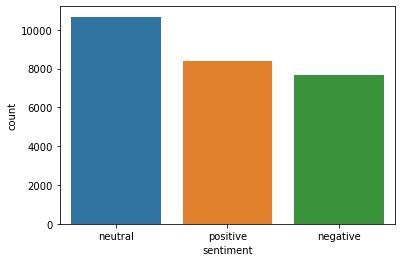

In [29]:
order = ['neutral','positive','negative']
sns.countplot(data = final_train,x = 'sentiment',order=order)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

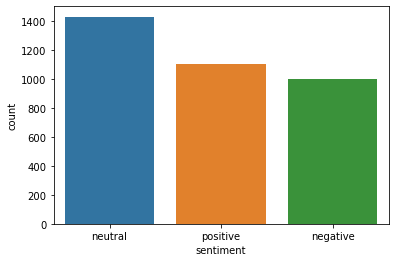

In [30]:
order = ['neutral','positive','negative']
sns.countplot(data = final_test,x = 'sentiment',order=order)

Observation : It can be seen from above two plots that both in train and test data ,they have similar kind of distribution of sentiments where majority tweets are neutral tweets followed by positive tweets and then negative tweets

#### Custom Function to be used in EDA

In [8]:
def kde_plot(dataframe,attribute,title):
    """This function will plot the kernel plot for a specific column in dataframe"""
    dataframe.plot(y = attribute, kind = 'kde', figsize=(20,8), grid = True)
    plt.title(title)
    plt.show()
    

In [9]:
def percentile(dataframe,attribute,range_tuple,step_size):
    """This function will print the percentiles values for the given range for a specific column in dataframe"""
    index = np.arange(range_tuple[0],range_tuple[1],step_size)
    percentile_arr = [np.percentile(dataframe[attribute], x) for x in index]
    return pd.DataFrame(percentile_arr,columns=[attribute]).set_index(index).T

In [10]:
#Reference: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

def stop_words(dataframe):
    """ This function calculates top 20 frequently occuring stopwords in the given specific columns of dataframe dataframe."""
    corpus=[]
    tweet= dataframe.str.split()
    tweet=tweet.values.tolist()
    corpus=[word for i in tweet for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
           dic[word]+=1
    top_stop_words=sorted(dic.items(),key=lambda x:x[1], reverse=True)[:20]
    x,y=zip(*top_stop_words)
    plt.figure(figsize=(10,15))
    plt.bar(x,y)
    plt.xlabel("Stopwords")
    plt.ylabel("Frequency of Stopwords")
    plt.title("Top 20 most frequent Stopwords")
    plt.show()     


In [73]:
def non_stop_words(dataframe):
    """ This function calculates top 20 frequently occuring non-stopwords in the given specific column of dataframe."""
    corpus=[]
    tweet= dataframe.str.split()
    tweet=tweet.values.tolist()
    corpus=[word for i in tweet for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word not in stop:
           dic[word]+=1
    top_non_stop_words=sorted(dic.items(),key=lambda x:x[1], reverse=True)[2:22]
    x,y=zip(*top_non_stop_words)
    plt.figure(figsize=(10,15))
    plt.bar(x,y)
    plt.xlabel("Non-Stopwords")
    plt.xticks(rotation='vertical')
    plt.ylabel("Frequency of Non-Stopwords")
    plt.title("Top 20 most frequent Non-Stopwords")
    plt.show()

In [13]:
#Reference: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
def create_wordcloud(dataframe):
    """ This function will generate the wordclouds"""
    corpus=[]
    stemmer=PorterStemmer()
    lemma=WordNetLemmatizer()
    for tweet in tqdm(dataframe):
        words=[i for i in word_tokenize(tweet) if (i not in stop)]

        words=[lemma.lemmatize(i) for i in words if len(i)>2]

        corpus.append(words)
    return corpus

def plot_wordcloud(corpus,title):
    """ This function will plot wordclouds"""
    wordcloud = WordCloud(background_color='white',
                          stopwords=set(STOPWORDS),
                          max_words=100,
                          max_font_size=30,
                          scale=3,
                          random_state=1)
    wordcloud=wordcloud.generate(str(corpus))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title(title)
    plt.show()

In [14]:
#Reference: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
def plot_top_ngrams_barchart(text, n=2):
    """ This function will show the plot with top 20 bi-gram words"""

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

In [76]:
def top_sentiment_words(dataframe,attribute,title):
    """This function with plot top 20 most common words used in tweets for a particular sentiments"""
    list_of_words = []
    for word in tqdm(dataframe[attribute].astype(str).values):
        words = [''.join(i) for i in word.split() if i not in stop]
        list_of_words.extend(words)
    top_common_words = Counter(list_of_words)
    df = pd.DataFrame(top_common_words.most_common() ,columns =['top_words','total_count'])
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(data = df[:20],x = 'total_count', y = 'top_words')
    plt.title(title)
    plt.show()

# 1."Text" Column

#### Length of sentence in text column

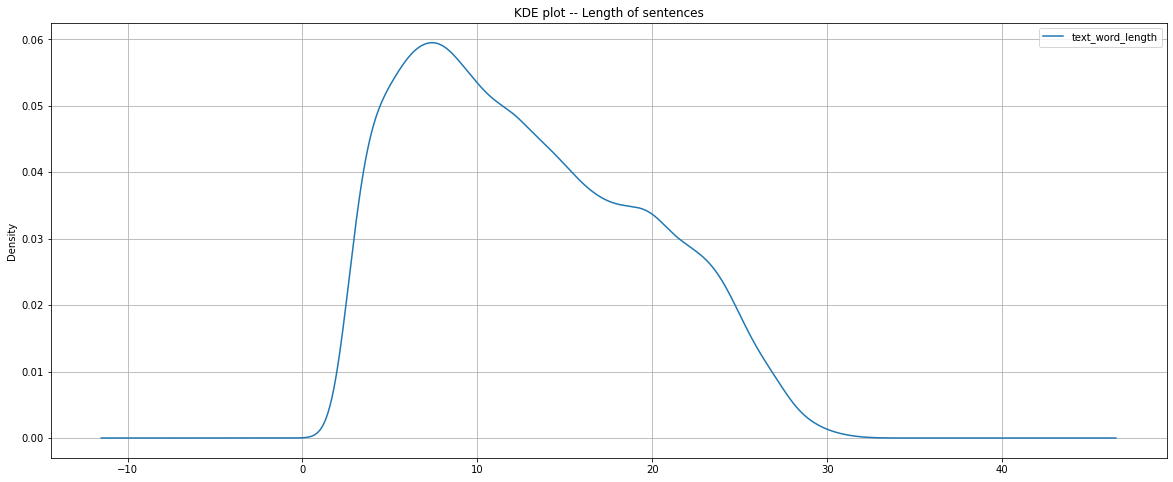

In [38]:
kde_plot(final_train,'text_word_length','KDE plot -- Length of sentences')

Observation : From the above distribution plot we found that most of the length of tweets lies in the ranges of 5-25,only handful sentences have tweet length more than 30

#### Percentile values

In [39]:
# Percentile values between 0-100 with step size of 10
percentile(final_train,'text_word_length',(0,101),10)

,0,10,20,30,40,50,60,70,80,90,100
text_word_length,3.0,5.0,7.0,8.0,10.0,12.0,14.0,17.0,19.0,23.0,32.0


From above it can be seen that 90th percentile value for length of tweet is 23 and 100th percentile value is 32,lets look at percentile value from 90-100

In [40]:
# Percentile values between 90-100 with step size of 1
percentile(final_train,'text_word_length',(90,101),1)

,90,91,92,93,94,95,96,97,98,99,100
text_word_length,23.0,23.0,23.0,24.0,24.0,24.0,25.0,26.0,26.0,27.0,32.0


From above it can be seen that 99th percentile value for length of tweet is 28 and 100th percentile value is 32,lets look at percentile value from 99-100

In [41]:
# Percentile values between 99-100 with step size of 0.1
percentile(final_train,'text_word_length',(99.1,100),0.1)

,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100.0
text_word_length,27.0,28.0,28.0,28.0,28.0,28.0,29.0,29.0,30.0,32.0


When we look at 99.8th,99.9th,100th value the difference is not much so we take max_length as 32 itself during deep learning model training

#### Length of sentence for Positive Sentiment

In [6]:
positive_sentiment_df =  final_train[final_train['sentiment']=='positive']
positive_sentiment_df.shape

(8366, 8)

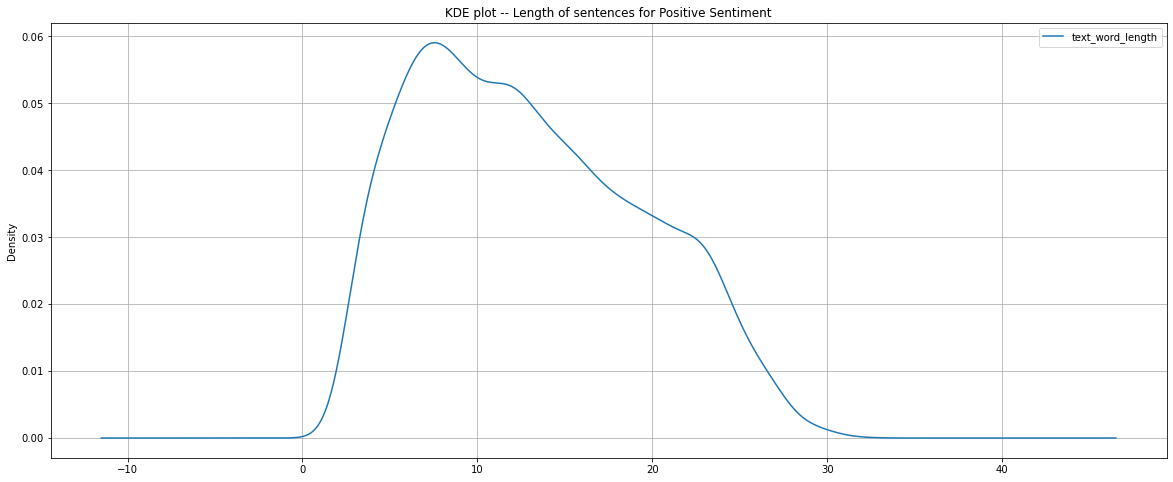

In [15]:
kde_plot(positive_sentiment_df,'text_word_length','KDE plot -- Length of sentences for Positive Sentiment')

Observation : From the above distribution plot it is right skewed non smooth curve and  we found that most of the length of tweets lies in the ranges of 5-25,only handful sentences have tweet length more than 30

#### Length of sentences for Negative Sentiments

In [16]:
negative_sentiment_df =  final_train[final_train['sentiment']=='negative']
negative_sentiment_df.shape

(7669, 8)

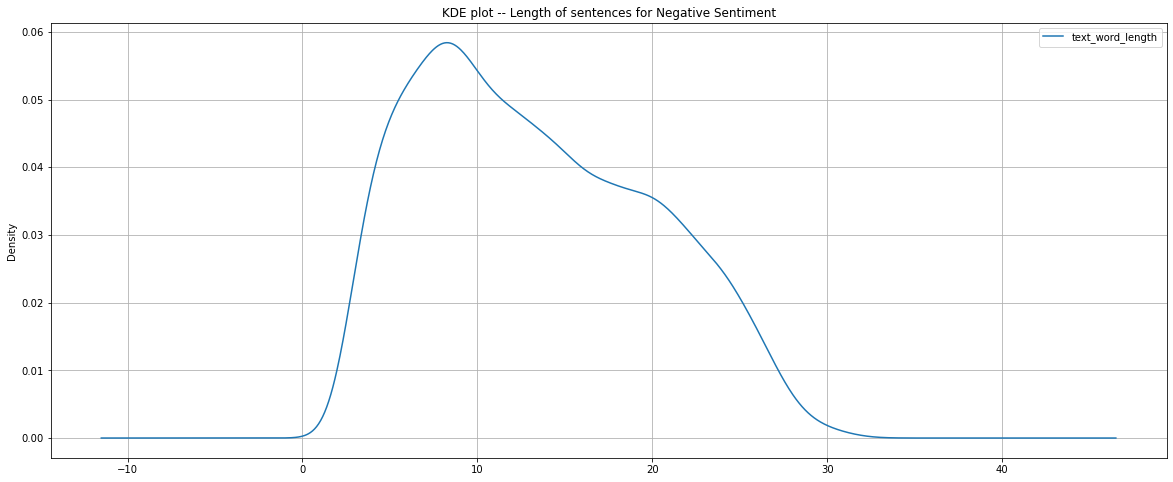

In [17]:
kde_plot(negative_sentiment_df,'text_word_length','KDE plot -- Length of sentences for Negative Sentiment')

Observation : From the above distribution plot it is right skewed but little smooth at peak side compare to positive plot and  we found that most of the length of tweets lies in the ranges of 5-25,only handful sentences have tweet length more than 30

#### Length of sentences for Neutral Sentiments

In [19]:
neutral_sentiment_df =  final_train[final_train['sentiment']=='neutral']
neutral_sentiment_df.shape

(10669, 8)

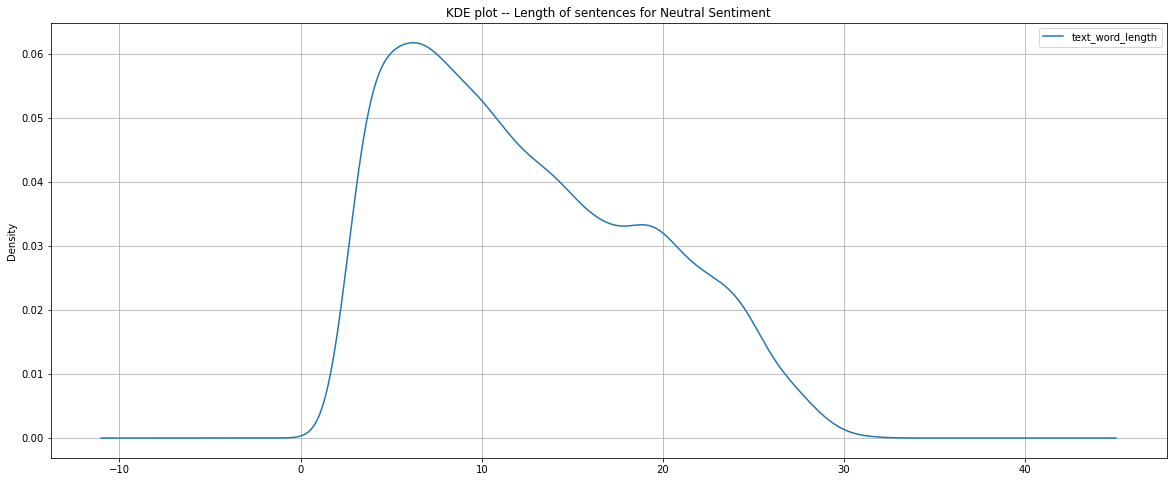

In [20]:
kde_plot(neutral_sentiment_df,'text_word_length','KDE plot -- Length of sentences for Neutral Sentiment')

Observation : From the above distribution plot it is right skewed smoot compare to positive and negative plot and we found that most of the length of tweets lies in the ranges of 5-25,only handful sentences have tweet length more than 30

#### Length of chracter in text column

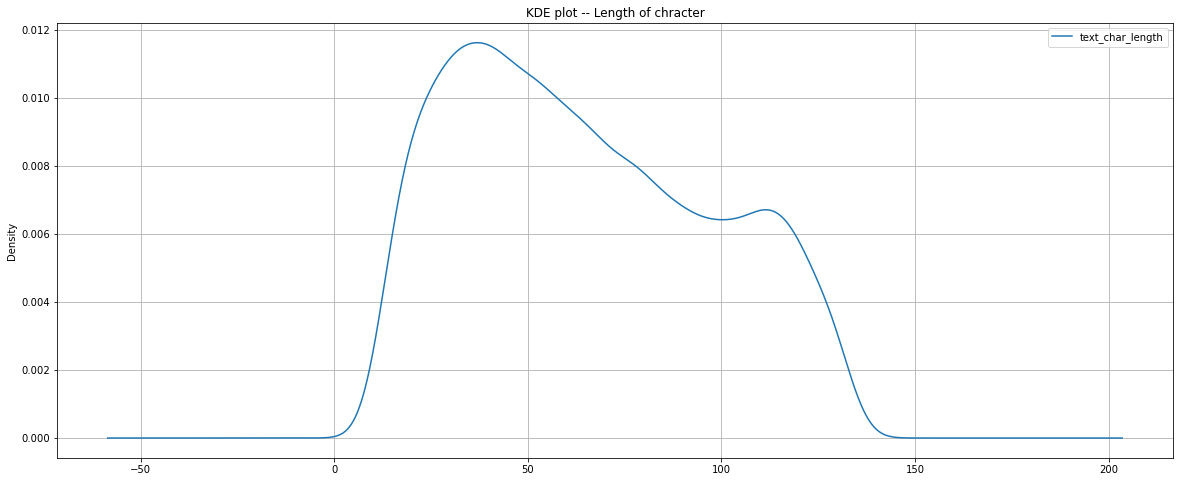

In [42]:
kde_plot(final_train,'text_char_length','KDE plot -- Length of chracter')

From the above distribution plot we found that most of the tweets have words between 25-75,very few tweets have words more than 140

#### Percentile Values

In [43]:
# Percentile values between 0-100 with step size of 10
percentile(final_train,'text_char_length',(0,101),10)

,0,10,20,30,40,50,60,70,80,90,100
text_char_length,7.0,24.0,33.0,41.0,50.0,60.0,71.0,83.0,98.0,114.0,138.0


We can see there is a some difference between 90th percentile and 100th percentile value,let look for percentile value between 90 and 100

In [44]:
# Percentile values between 90-100 with step size of 1
percentile(final_train,'text_char_length',(90,101),1)

,90,91,92,93,94,95,96,97,98,99,100
text_char_length,114.0,115.0,117.0,118.0,120.0,121.0,123.0,125.0,128.0,130.0,138.0


In [45]:
# Percentile values between 99-100 with step size of 0.1
percentile(final_train,'text_char_length',(99.1,100),0.1)

,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100.0
text_char_length,131.0,131.0,131.0,132.0,132.0,132.188,133.0,134.0,135.0,138.0


From the above two percentile data we can assume that maximum numbers of characeter should be 119

#### Stopwords

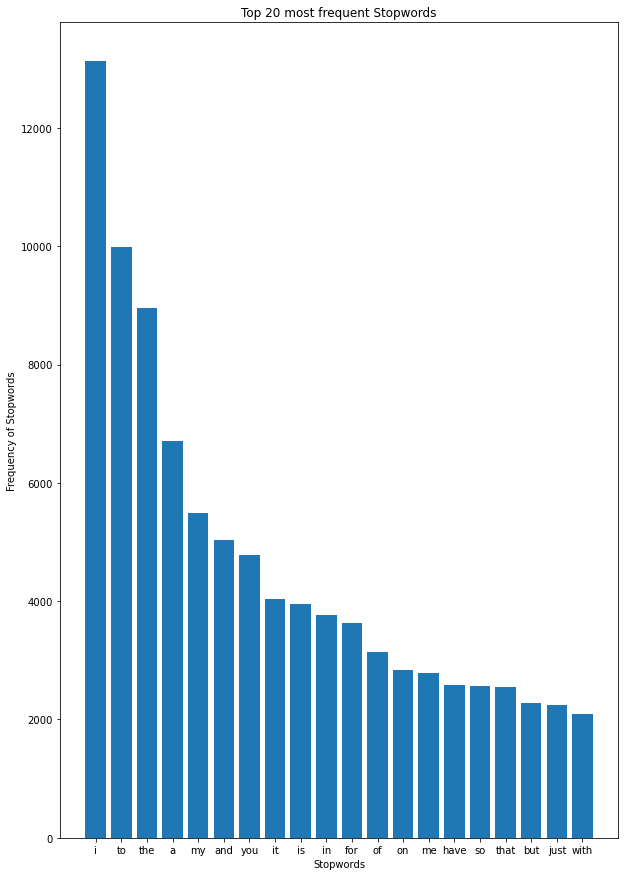

In [46]:
stop_words(final_train['text'])

From above plot it can be seen that stopwords "to","the","a","my","and" are most frequently used in tweets

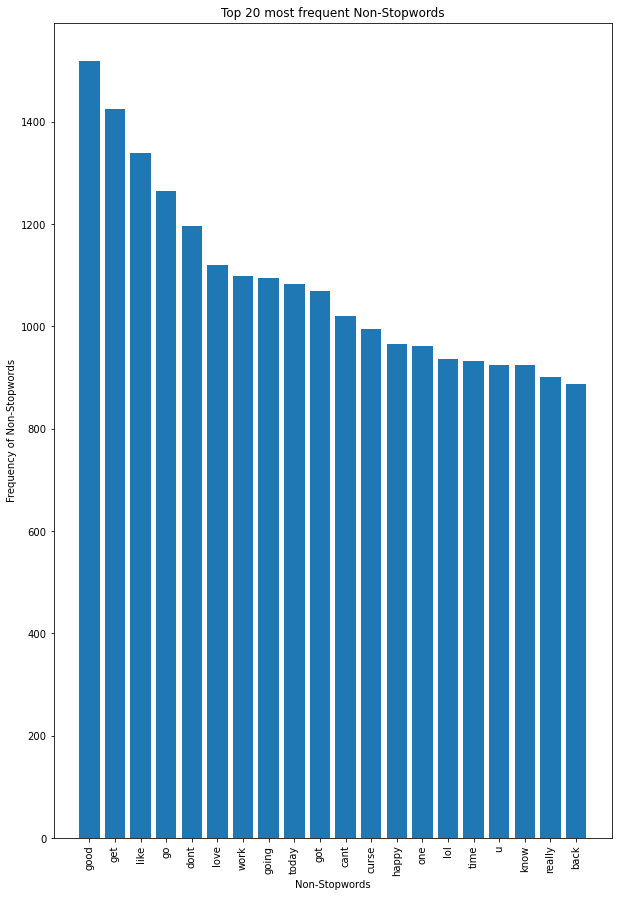

In [74]:
non_stop_words(final_train['text'])

From the abive plot it can be seen that the top non stopwords are "get","like","day","go","good" which are more frequently used in tweets

#### WordCloud

100%|██████████████████████████████████████████████████████████████████████████| 26704/26704 [00:09<00:00, 2687.44it/s]


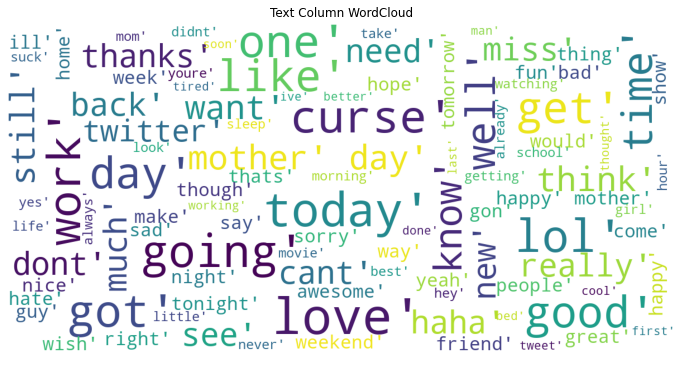

In [49]:
corpus = create_wordcloud(final_train['text'])
plot_wordcloud(corpus,"Text Column WordCloud")

From above Word cloud we can see that "curse","today","going","good","time","day","lol","love","work","like" are the words that are frequently used in tweets

#### NGram Analysis

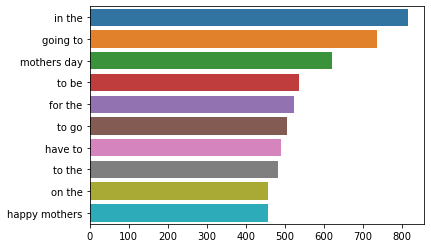

In [50]:
plot_top_ngrams_barchart(final_train['text'],2)

Th top bi-grams used in tweets are "in the","going to","mothers day"

#### Top 20 words in Postive Sentiment Tweet 

100%|███████████████████████████████████████████████████████████████████████████| 8366/8366 [00:00<00:00, 87249.88it/s]


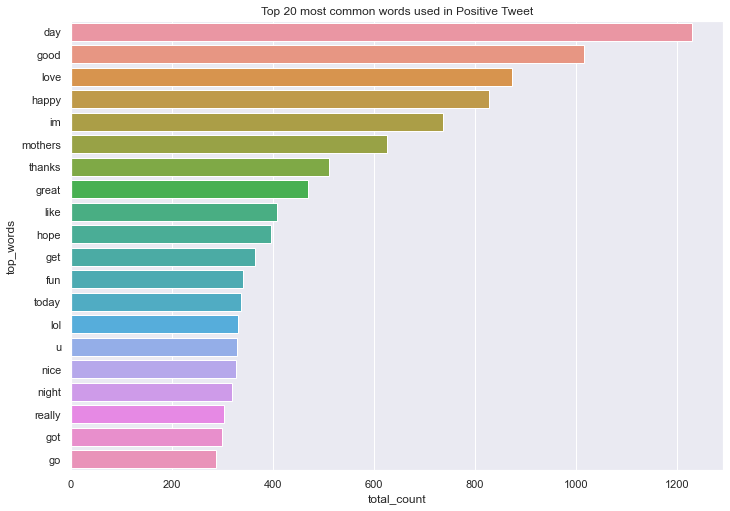

In [83]:
top_sentiment_words(positive_sentiment_df,"text","Top 20 most common words used in Positive Tweet")

Observation : The top words in positive tweets are "day","good","love","happy" etc

#### Top 20 words in Negative Sentiment Tweet

100%|███████████████████████████████████████████████████████████████████████████| 7669/7669 [00:00<00:00, 77672.48it/s]


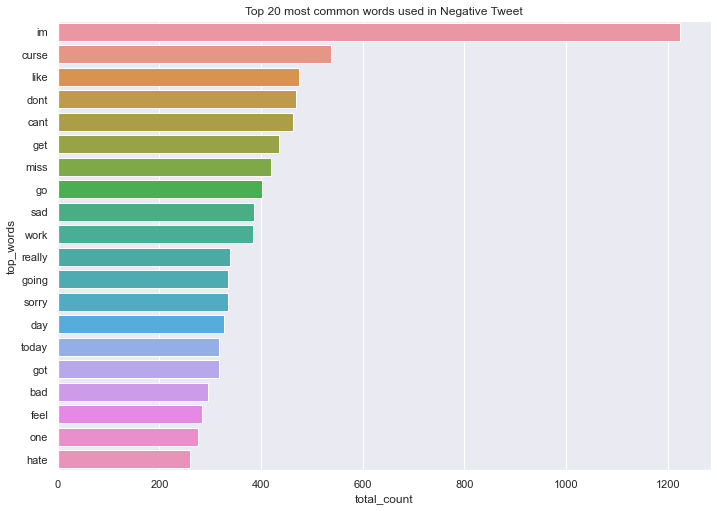

In [82]:
top_sentiment_words(negative_sentiment_df,"text","Top 20 most common words used in Negative Tweet")

Observation : The top words in negative tweets are "im","curse","like","dont","cant" etc

#### Top 20 words in Neutral Sentiment Tweet

100%|█████████████████████████████████████████████████████████████████████████| 10669/10669 [00:00<00:00, 84837.59it/s]


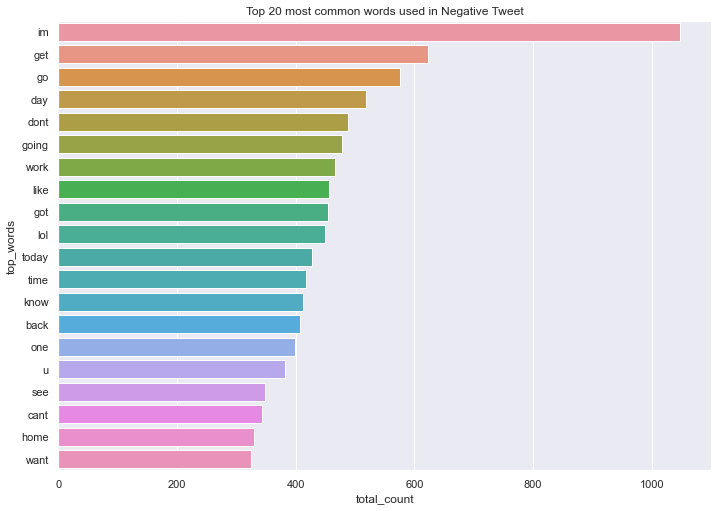

In [81]:
top_sentiment_words(neutral_sentiment_df,"text","Top 20 most common words used in Negative Tweet")

Observation : The top words in neutral tweets are "im","get","go","day","dont","going" etc

# 2. "Selected_Text / Phrase" Column

#### Length of phrase in selected_text column

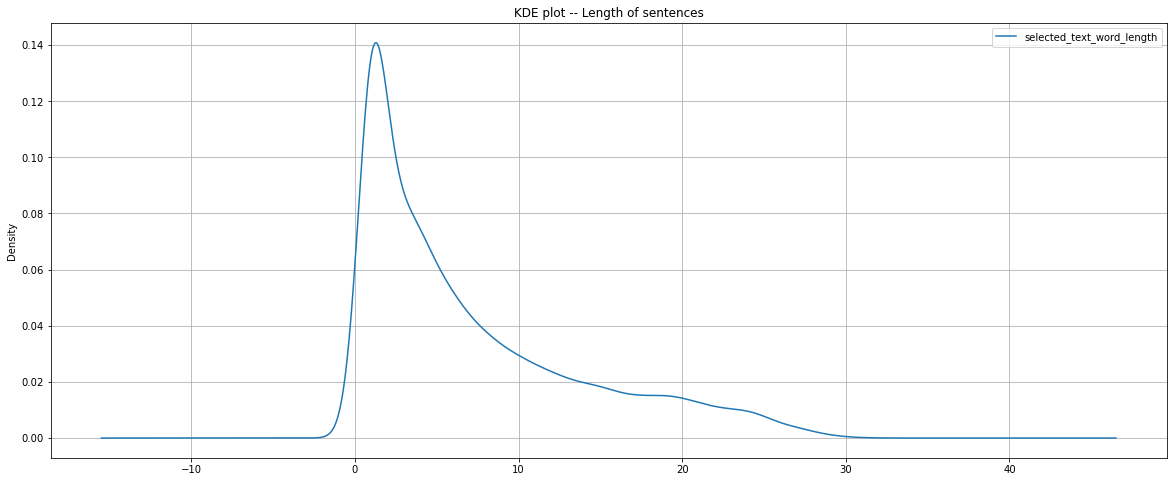

In [45]:
kde_plot(final_train,'selected_text_word_length','KDE plot -- Length of sentences')

Observation : From the above distribution plot we found that most of the length of phrases lies in the ranges of 2-5,only handful phrases have length more than 25 which may be belong to neutral sentiment,Lets plot the same based on sentiments seperately

#### Percentile values

In [46]:
# Percentile values between 0-100 with step size of 10
percentile(final_train,'selected_text_word_length',(0,101),10)

,0,10,20,30,40,50,60,70,80,90,100
selected_text_word_length,0.0,1.0,1.0,2.0,3.0,5.0,6.0,9.0,13.0,18.0,31.0


From above it can be seen that 90th percentile value for length of phrase is 18 and 100th percentile value is 31 ,there is a huge difference,lets look at percentile value from 90-100

In [48]:
# Percentile values between 90-100 with step size of 1
percentile(final_train,'selected_text_word_length',(90,101),1)

,90,91,92,93,94,95,96,97,98,99,100
selected_text_word_length,18.0,19.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,31.0


From above it can be seen that 99th percentile value for length of phrase is 26 and 100th percentile value is 31,not much bigger difference,lets look at percentile value from 99-100

In [49]:
# Percentile values between 99-100 with step size of 0.1
percentile(final_train,'selected_text_word_length',(99.1,100),0.1)

,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100.0
selected_text_word_length,26.0,26.0,27.0,27.0,27.0,27.0,28.0,28.0,29.0,31.0


When we look at 99.8th,99.9th,100th value the difference is not much so we take max_length as 18 itself during deep learning model training

#### Length of phrase for Positive Sentiment

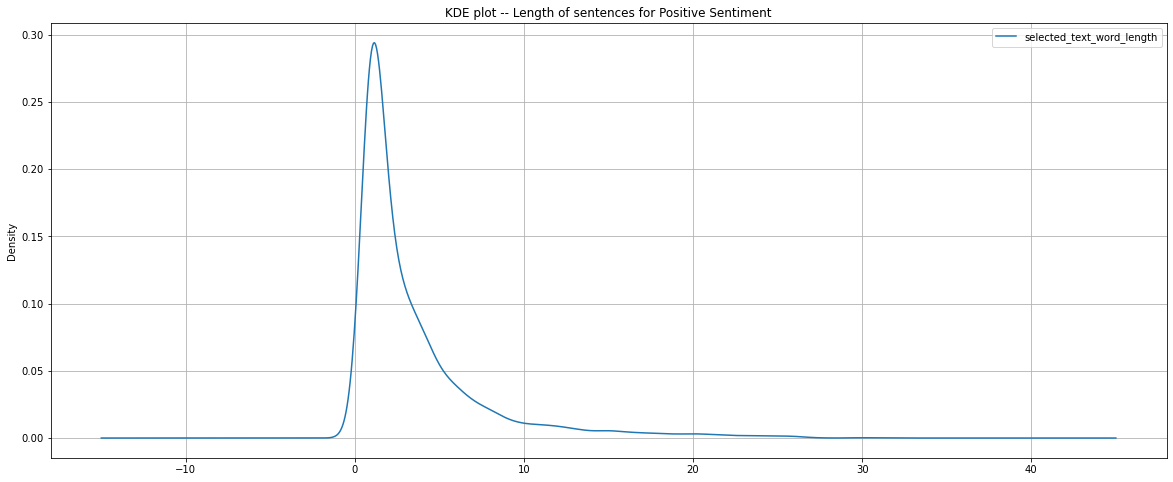

In [51]:
kde_plot(positive_sentiment_df,'selected_text_word_length','KDE plot -- Length of sentences for Positive Sentiment')

Observation : From the above distribution plot it is right skewed ,sharply peaked smooth curve and we found that most of the length of phrases lies in the ranges of 2-5,only handful sentences have phrase length more than 10

#### Length of phrases for Negative Sentiments

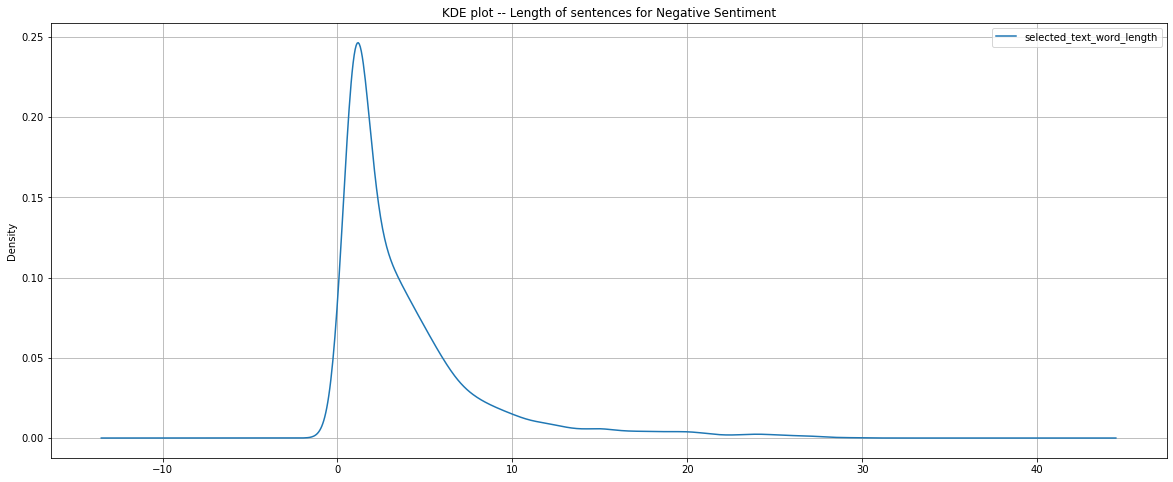

In [52]:
kde_plot(negative_sentiment_df,'selected_text_word_length','KDE plot -- Length of sentences for Negative Sentiment')

Observation : From the above distribution plot it is right skewed ,sharply peaked smooth curve and we found that most of the length of phrases lies in the ranges of 2-5,only handful sentences have phrase length more than 20

#### Length of phrases for Neutral Sentiments

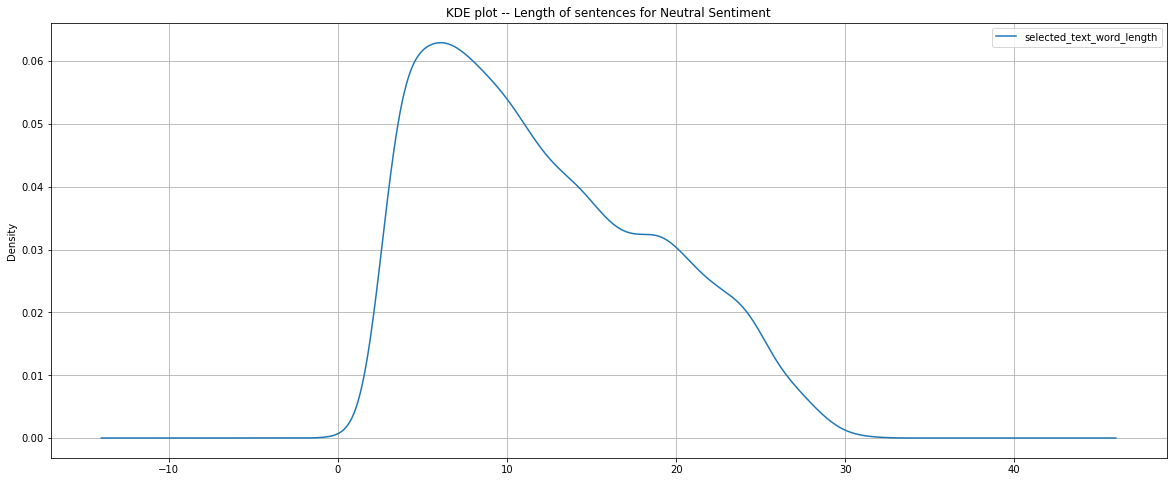

In [53]:
kde_plot(neutral_sentiment_df,'selected_text_word_length','KDE plot -- Length of sentences for Neutral Sentiment')

Observation : From the above distribution plot it is right skewed ,little non smooth curve and we found that most of the length of phrases lies in the ranges of 5-20,only handful sentences have phrase length more than 30,Thus this proves that the larger length of phrase we looked were belong to actually neutral sentiment

#### Length of chracter in selected_text column

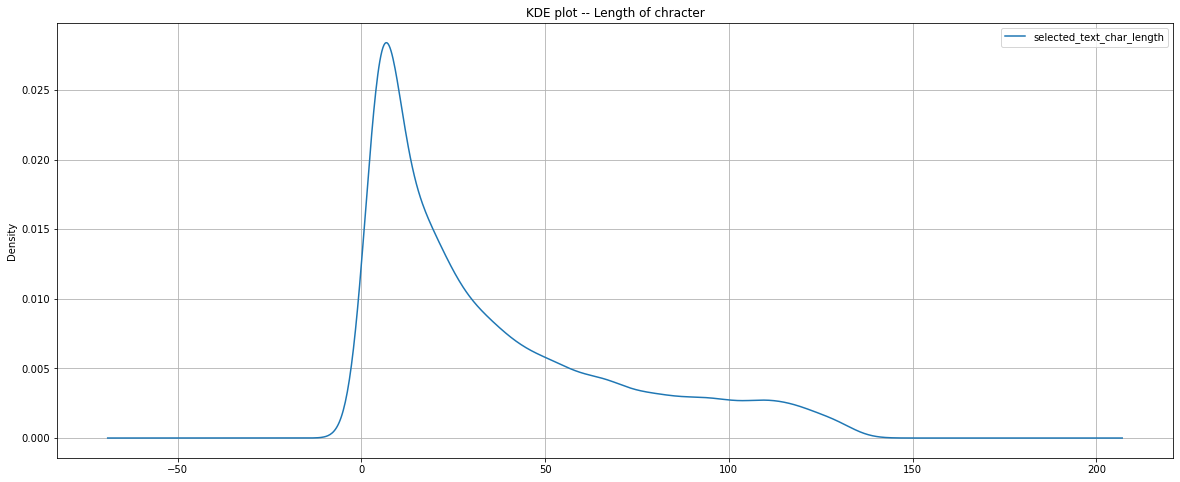

In [54]:
kde_plot(final_train,'selected_text_char_length','KDE plot -- Length of chracter')

From the above distribution plot we found that most of the phrases have words between 5-50,very few phrases have words more than 135-140

#### Percentile Values

In [55]:
# Percentile values between 0-100 with step size of 10
percentile(final_train,'selected_text_char_length',(0,101),10)

,0,10,20,30,40,50,60,70,80,90,100
selected_text_char_length,0.0,5.0,6.0,10.0,16.0,22.0,31.0,44.0,63.0,91.0,138.0


We can see there is a huge difference between 90th percentile and 100th percentile value,let look for percentile value between 90 and 100

In [56]:
# Percentile values between 90-100 with step size of 1
percentile(final_train,'selected_text_char_length',(90,101),1)

,90,91,92,93,94,95,96,97,98,99,100
selected_text_char_length,91.0,95.0,98.0,102.0,106.0,109.0,113.0,117.0,121.0,126.0,138.0


We can see there is a some difference between 99th percentile and 100th percentile value,let look for percentile value between 99.1 and 100

In [57]:
# Percentile values between 99-100 with step size of 0.1
percentile(final_train,'selected_text_char_length',(99.1,100),0.1)

,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100.0
selected_text_char_length,127.0,128.0,128.0,129.0,130.0,130.0,131.0,132.0,133.297,138.0


We can see there is a some difference between 99.1th percentile and 100th percentile value,we can assume the maximum numbers of character is 91.

#### Stopwords

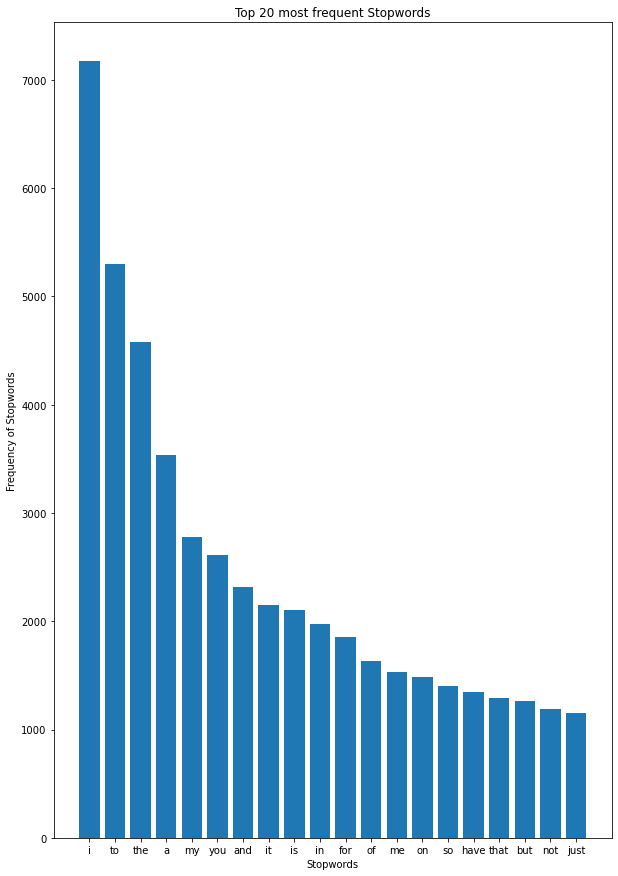

In [59]:
stop_words(final_train['selected_text'].astype(str))

From above plot it can be seen that stopwords "i","to","the","a","my","you" are most frequently used in phrases

#### Non Stop Words

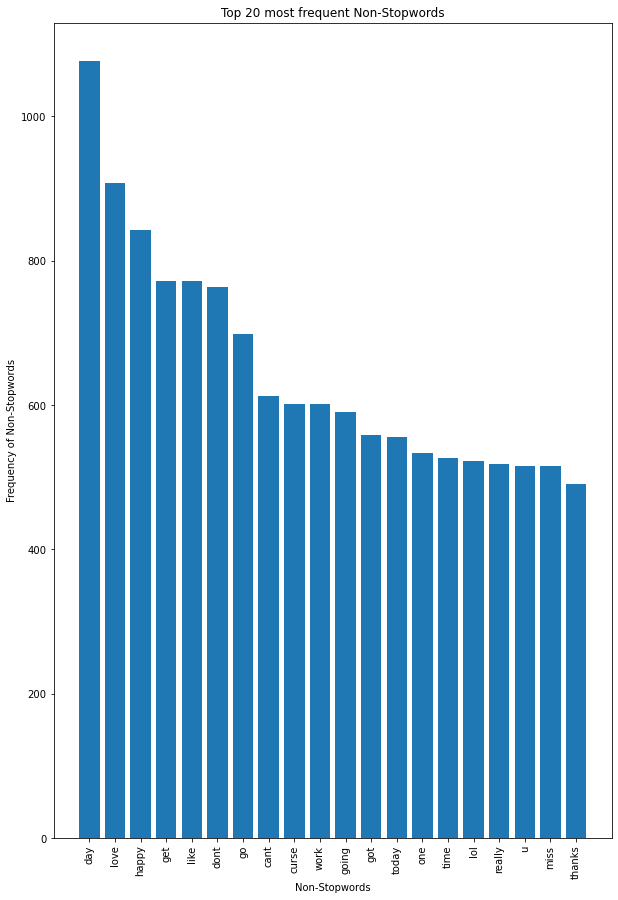

In [75]:
non_stop_words(final_train['selected_text'].astype(str))

From the abive plot it can be seen that the top non stopwords are "day","love","happy","get","like" which are more frequently used in phrases

#### WordCloud

100%|██████████████████████████████████████████████████████████████████████████| 26704/26704 [00:06<00:00, 4230.67it/s]


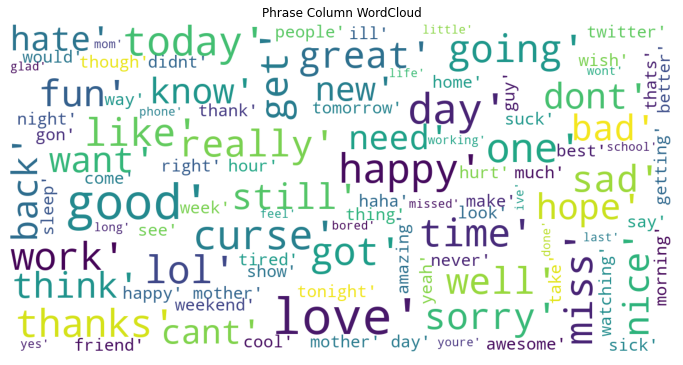

In [62]:
corpus = create_wordcloud(final_train['selected_text'].astype(str))
plot_wordcloud(corpus,"Phrase Column WordCloud")

From above Word cloud we can see that "good","ciurse","happy","love","lol","time","going","day" etc are the words that are frequently used in phrases

#### NGram Analysis

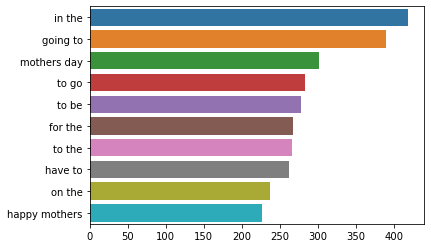

In [64]:
plot_top_ngrams_barchart(final_train['selected_text'].astype(str),2)

The top bi-grams used in phrases are "in the","going to","mothers day"

#### Top 20 words in Postive Sentiment Phrases

100%|██████████████████████████████████████████████████████████████████████████| 8366/8366 [00:00<00:00, 239448.81it/s]


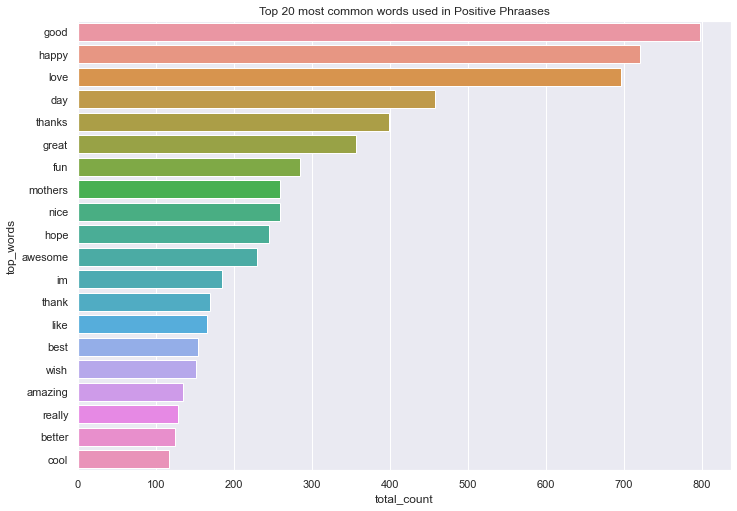

In [80]:
top_sentiment_words(positive_sentiment_df,"selected_text","Top 20 most common words used in Positive Phraases")

Observation : The top words in positive phrases are "good","happy","love","day" etc

#### Top 20 words in Negative Sentiment Phrases

100%|██████████████████████████████████████████████████████████████████████████| 7669/7669 [00:00<00:00, 153971.17it/s]


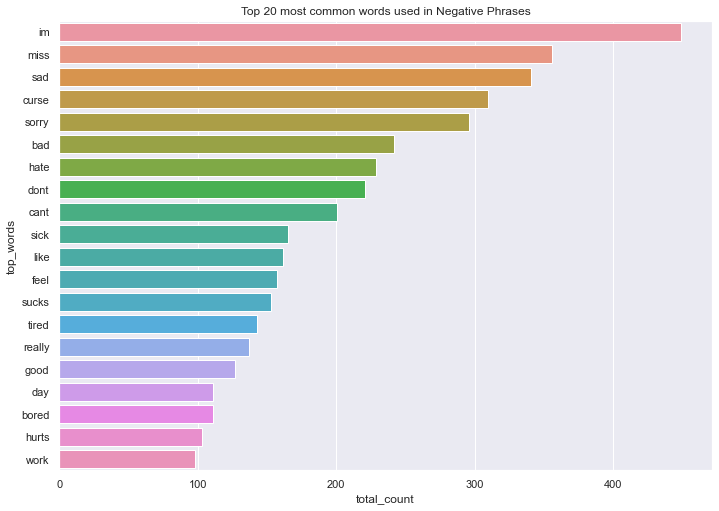

In [79]:
top_sentiment_words(negative_sentiment_df,"selected_text","Top 20 most common words used in Negative Phrases")

Observation : The top words in negative Phrases are "im","miss","sad","curse","sorry","bad" etc

#### Top 20 words in Neutral Sentiment Tweet

100%|█████████████████████████████████████████████████████████████████████████| 10669/10669 [00:00<00:00, 81702.80it/s]


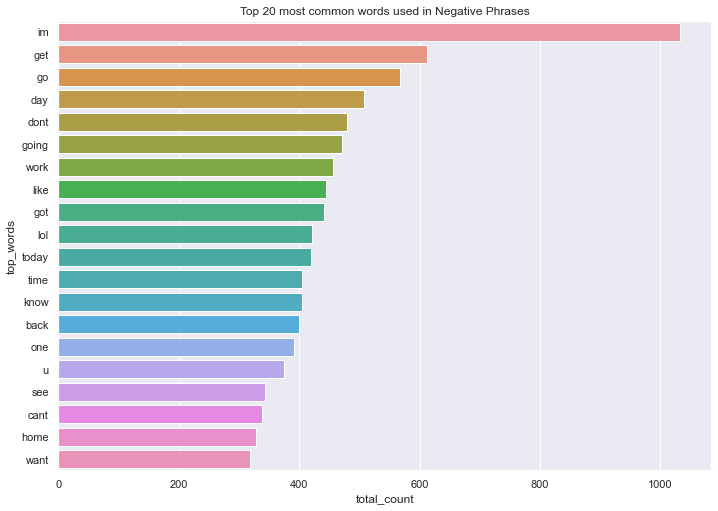

In [78]:
top_sentiment_words(neutral_sentiment_df,"selected_text","Top 20 most common words used in Negative Phrases")

Observation : The top words in neutral phrases are "im","get","go","day","dont","going" etc

## Conclusion:

1. The original data was having a total of 27481 rows and 4 columns.
2. The final data after  performing preprocessing ,removing all duplicates and null rows and for sentence length <=3 we are left with total rows of 26704 and we came up with additional 4 columns to do Exploratory Data Analysis.
3. The percentage of data retained after removing unrequired rows is 97.172%
4. We will train our model on these final data which look like shown below in next code snippet

In [9]:
final_train.head()

,textID,text,selected_text,sentiment,text_word_length,selected_text_word_length,text_char_length,selected_text_char_length
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,7,7,33,33
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,10,2,42,8
2,088c60f138,my boss is bullying me,bullying me,negative,5,2,22,11
3,9642c003ef,what interview leave me alone,leave me alone,negative,5,3,29,14
4,358bd9e861,sons of curse why couldnt they put them on the...,sons of curse,negative,14,3,73,13


## Future Task:
In next task we will make data ready for model as the data is text so we will add <start> at the begining of tweet and phrases and add <end> in end of tweet and phrases ,the will tokenize and sequence padding after will data will be ready in understand form for machine and then train deep learning algorithm on newly prepared data.